# Annotation Statistics

## Step 1: Load Libraries

In [1]:
# Install all required packages
!pip install pandas krippendorff statsmodels scikit-learn seaborn matplotlib numpy



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
import krippendorff
from statsmodels.stats.inter_rater import fleiss_kappa
from sklearn.metrics import cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.inter_rater import aggregate_raters, fleiss_kappa
import itertools
import seaborn as sns
from scipy.stats import entropy
from sklearn.cluster import KMeans
from scipy.special import rel_entr
from scipy.stats import entropy
import itertools




## Step 2: Read and Prepare Data

In [5]:
df = pd.read_csv("./gold_dataset.csv")

#### **Data Cleaning**

<p> We are going to make changes to the dataframe, so that it follows an easy to read and use format.</p>

<p> First, we note that HITId identifies speeches, WorkerId identifies workers, and Input.label is the annotation </p>


In [ ]:
# only keep needed columns and rename 
df_clean = df[['HITId', 'WorkerId', 'Input.parameter', 'Input.label']].copy() #remove unnecessary columns
df_clean.rename(columns={
    'HITId': 'speech_id',
    'WorkerId': 'worker_id',
    'Input.parameter': 'parameter',
    'Input.label': 'label'
}, inplace=True)

# extra cleaning, dropping nulls, making sure all labels are ints, 
df_clean = df_clean.sort_values(by=['parameter', 'speech_id', 'worker_id']).reset_index(drop=True)

# Final preview

df_clean


,speech_id,worker_id,parameter,label
0,31ANT7FQOVKX4DA0R4UV4SEMMZW5HK,A1NBQ61Y6KO3O9,Par303_Governmental and Administrative Efficiency,1
1,31ANT7FQOVKX4DA0R4UV4SEMMZW5HK,A3GS2NTQ4XU059,Par303_Governmental and Administrative Efficiency,1
2,31ANT7FQOVKX4DA0R4UV4SEMMZW5HK,APXGSUB250NVH,Par303_Governmental and Administrative Efficiency,1
3,31MBOZ6PBB9KPU25XZW1AQD3VXRLCF,A1NBQ61Y6KO3O9,Par303_Governmental and Administrative Efficiency,0
4,31MBOZ6PBB9KPU25XZW1AQD3VXRLCF,A3GS2NTQ4XU059,Par303_Governmental and Administrative Efficiency,0
...,...,...,...,...
655,3WRKFXQBPYPV2WV48OHDF1DUHHFIY6,A1X47COW2Y9SEL,Par701702_LabourGroups,2
656,3WRKFXQBPYPV2WV48OHDF1DUHHFIY6,A335R4YE2E34H6,Par701702_LabourGroups,2
657,3ZURAPD29V5E2ZIBVR4JYHPSURQF10,A1NBQ61Y6KO3O9,Par701702_LabourGroups,2
658,3ZURAPD29V5E2ZIBVR4JYHPSURQF10,A1X47COW2Y9SEL,Par701702_LabourGroups,2


In [122]:
df_clean.columns

Index(['speech_id', 'worker_id', 'parameter', 'label'], dtype='object')

**Secondary Cleaning:**

Create 10 different tables for each parameter

In [128]:
for param in df['Input.parameter'].unique():
    safe_name = "df_" + (
        param.replace('-', '_')
             .replace('&', 'And')
             .replace('.', '')
             .replace(' ', '_')
    )

    df_param = df[df['Input.parameter'] == param].drop_duplicates(subset=['HITId', 'WorkerId'])

    # Pivot without altering index permanently
    pivot = df_param.pivot(
        index='HITId',
        columns='WorkerId',
        values='Input.label'
    ).reset_index()  # <-- Keep HITId as a column

    # Optionally, sort columns so HITId is first
    cols = ['HITId'] + [col for col in pivot.columns if col != 'HITId']
    pivot = pivot[cols]

    globals()[safe_name] = pivot
    print(f"Created variable: {safe_name}")



Created variable: df_Par303_Governmental_and_Administrative_Efficiency
Created variable: df_Par405_Corporatism
Created variable: df_Par402_Incentives
Created variable: df_Par410416_EconomicGrowthAntiGrowth
Created variable: df_Par408_EconomicGoals
Created variable: df_Par409_KeynesianDemandManagement
Created variable: df_Par404_EconomicPlanning
Created variable: df_Par401403_FreeMarket_MarketRegulation
Created variable: df_Par701702_LabourGroups
Created variable: df_Par411_TechnologyAndInfrastructure


In [129]:
df_Par411_TechnologyAndInfrastructure.columns

Index(['HITId', 'A1BQ37ZGUM16XI', 'A1NBQ61Y6KO3O9', 'A1X47COW2Y9SEL',
       'A335R4YE2E34H6', 'A3GS2NTQ4XU059', 'APXGSUB250NVH'],
      dtype='object', name='WorkerId')

## First Try: Krippendorff’s Alpha 

Handles missing data, works for nominal/ordinal; More flexible than Fleiss; can handle ordinal distance metrics too. First we will use Krippendorff's Alpha to compare agreement scores per parameter. 

*Defining Arrays*

In [103]:
# define dataframes, workers, etc. 
param_dfs = {
    "Par303_Governmental_and_Administrative_Efficiency": df_Par303_Governmental_and_Administrative_Efficiency,
    "Par405_Corporatism": df_Par405_Corporatism,
    "Par402_Incentives": df_Par402_Incentives,
    "Par410416_EconomicGrowthAntiGrowth": df_Par410416_EconomicGrowthAntiGrowth,
    "Par408_EconomicGoals": df_Par408_EconomicGoals,
    "Par409_KeynesianDemandManagement": df_Par409_KeynesianDemandManagement,
    "Par404_EconomicPlanning": df_Par404_EconomicPlanning,
    "Par401403_FreeMarket_MarketRegulation": df_Par401403_FreeMarket_MarketRegulation,
    "Par701702_LabourGroups": df_Par701702_LabourGroups,
    "Par411_TechnologyAndInfrastructure": df_Par411_TechnologyAndInfrastructure
}

workers = [
    'A1BQ37ZGUM16XI', 
    'A1NBQ61Y6KO3O9', 
    'A1X47COW2Y9SEL', 
    'A335R4YE2E34H6', 
    'A3GS2NTQ4XU059', 
    'APXGSUB250NVH'
]


In [130]:

for param_name, df_param in param_dfs.items():
    try:
        # cprep data
        ratings = df_param.drop(columns='HITId')
        
        # Compute alpha
        print(f"------------------\nParameter: {param_name}")
        alpha = krippendorff.alpha(reliability_data=ratings, level_of_measurement='nominal')
        print(f"Krippendorff’s Alpha: {alpha:.3f}")
    except Exception as e:
        print(f"Error computing alpha for {param_name}: {e}")

------------------
Parameter: Par303_Governmental_and_Administrative_Efficiency
Krippendorff’s Alpha: -0.067
------------------
Parameter: Par405_Corporatism
Krippendorff’s Alpha: -0.082
------------------
Parameter: Par402_Incentives
Krippendorff’s Alpha: -0.024
------------------
Parameter: Par410416_EconomicGrowthAntiGrowth
Krippendorff’s Alpha: -0.034
------------------
Parameter: Par408_EconomicGoals
Krippendorff’s Alpha: -0.026
------------------
Parameter: Par409_KeynesianDemandManagement
Krippendorff’s Alpha: -0.068
------------------
Parameter: Par404_EconomicPlanning
Krippendorff’s Alpha: -0.048
------------------
Parameter: Par401403_FreeMarket_MarketRegulation
Krippendorff’s Alpha: -0.041
------------------
Parameter: Par701702_LabourGroups
Krippendorff’s Alpha: -0.060
------------------
Parameter: Par411_TechnologyAndInfrastructure
Krippendorff’s Alpha: -0.042


**Interpretation: Negative krippendorff scores**<br>

This means annotators disagreed more than expected. <br>

This often means: Labels were applied inconsistently; The task was unclear, or the instructions were ambiguous; There might be confusion between label values (e.g., when to use 0 vs. 2); Or raters may be labeling based on different interpretations of the same text.

## Second Try: Pairwise Cohen Kappa (not working right now)

standard model but can only compare two annotators; therefore, we take a pair-wise approach and loop through annotator pairs

In [ ]:
# annotators = ratings.columns #specify annotators 
# print('-------------------')

# min_overlap = 10

# for a1, a2 in itertools.combinations(annotators, 2):
#     pair = ratings[[a1, a2]].dropna()
#     if len(pair) >= min_overlap:
#         score = cohen_kappa_score(pair[a1], pair[a2])
#         print(f"{a1} vs {a2}: Cohen's Kappa = {score:.3f} (n={len(pair)})")
#     else:
#         print(f"{a1} vs {a2}: not enough overlap (n={len(pair)})")


In [ ]:


# kappa_matrix = pd.DataFrame(index=annotators, columns=annotators, dtype=float)

# for a1, a2 in itertools.combinations(annotators, 2):
#     pair = ratings[[a1, a2]].dropna()
#     if not pair.empty:
#         k = cohen_kappa_score(pair[a1], pair[a2])
#         kappa_matrix.loc[a1, a2] = k
#         kappa_matrix.loc[a2, a1] = k
#     else:
#         kappa_matrix.loc[a1, a2] = None
#         kappa_matrix.loc[a2, a1] = None

# sns.heatmap(kappa_matrix, annot=True, cmap="coolwarm", center=0)
# plt.title("Pairwise Cohen's Kappa")
# plt.show()


Cohen's Kappa will likely not work - even with a pairwise approach. It may be more benificial to do create an aggregate table 

## Third Try: Fleiss' Kappa 

In [120]:
for param_name, df_param in param_dfs.items():
    try:
        # prep data
        ratings = df_param.drop(columns='HITId')
        counts = []

        # Compute Fleiss' Kappa
        print(ratings)
        kappa = fleiss_kappa(ratings)
        print(f"------------------\nParameter: {param_name}")
        print(f"Fleiss' Kappa: {kappa:.3f}")
        
    except Exception as e:
        print(f"Error computing Fleiss' Kappa for {param_name}: {e}")

WorkerId  A1NBQ61Y6KO3O9  A1X47COW2Y9SEL  A335R4YE2E34H6  A3GS2NTQ4XU059  \
0                    1.0             NaN             NaN             1.0   
1                    0.0             NaN             NaN             0.0   
2                    NaN             0.0             0.0             0.0   
3                    0.0             0.0             0.0             NaN   
4                    1.0             1.0             1.0             NaN   
5                    0.0             0.0             0.0             NaN   
6                    1.0             NaN             1.0             1.0   
7                    0.0             NaN             0.0             0.0   
8                    0.0             0.0             0.0             NaN   
9                    0.0             NaN             NaN             0.0   
10                   1.0             NaN             1.0             NaN   
11                   1.0             NaN             1.0             1.0   
12          

## Visualizing Disagreement

## Annotation Coverage - Other Statistics

**How many samples each annotator labeled**

In [106]:
coverage = ratings.notna().sum()
print(coverage)


WorkerId
A1BQ37ZGUM16XI     1
A1NBQ61Y6KO3O9    16
A1X47COW2Y9SEL    13
A335R4YE2E34H6    14
A3GS2NTQ4XU059     9
APXGSUB250NVH      7
dtype: int64


**Missing Annotations**

Which annotators skipped what?

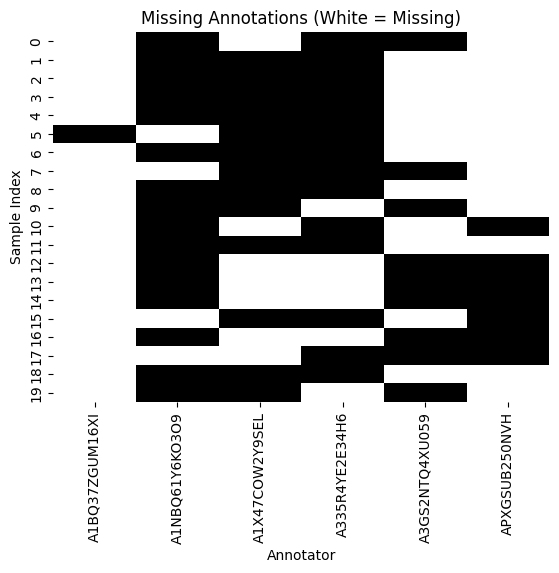

In [107]:
sns.heatmap(ratings.isna(), cbar=False, cmap='gray')
plt.title("Missing Annotations (White = Missing)")
plt.xlabel("Annotator")
plt.ylabel("Sample Index")
plt.show()

**Divergence Overall**

How different are annotators' distributions? *KL divergence (Kullback–Leibler divergence) is a way to measure how different one probability distribution is from another.*

In [ ]:
def kl_divergence(p, q):
    '''kl_div helper to avoid division by 0
    '''
    p = np.array(p) + 1e-10
    q = np.array(q) + 1e-10
    return np.sum(rel_entr(p, q))

label_dists = ratings.apply(lambda col: col.value_counts(normalize=True).reindex([0, 1, 2]).fillna(0))


for a1, a2 in itertools.combinations(label_dists.columns, 2):
    kl = kl_divergence(label_dists[a1], label_dists[a2])
    print(f"{a1} vs {a2}: KL Divergence = {kl:.3f}")


A1BQ37ZGUM16XI vs A1NBQ61Y6KO3O9: KL Divergence = 0.693
A1BQ37ZGUM16XI vs A1X47COW2Y9SEL: KL Divergence = 0.773
A1BQ37ZGUM16XI vs A335R4YE2E34H6: KL Divergence = 0.847
A1BQ37ZGUM16XI vs A3GS2NTQ4XU059: KL Divergence = 0.811
A1BQ37ZGUM16XI vs APXGSUB250NVH: KL Divergence = 0.336
A1NBQ61Y6KO3O9 vs A1X47COW2Y9SEL: KL Divergence = 0.003
A1NBQ61Y6KO3O9 vs A335R4YE2E34H6: KL Divergence = 0.010
A1NBQ61Y6KO3O9 vs A3GS2NTQ4XU059: KL Divergence = 0.006
A1NBQ61Y6KO3O9 vs APXGSUB250NVH: KL Divergence = 0.101
A1X47COW2Y9SEL vs A335R4YE2E34H6: KL Divergence = 0.002
A1X47COW2Y9SEL vs A3GS2NTQ4XU059: KL Divergence = 0.001
A1X47COW2Y9SEL vs APXGSUB250NVH: KL Divergence = 0.140
A335R4YE2E34H6 vs A3GS2NTQ4XU059: KL Divergence = 0.001
A335R4YE2E34H6 vs APXGSUB250NVH: KL Divergence = 0.177
A3GS2NTQ4XU059 vs APXGSUB250NVH: KL Divergence = 0.159


Do annotators agree with the majority ?

In [113]:
majority_vote = ratings.mode(axis=1)[0]

for annotator in ratings.columns:
    match = (ratings[annotator] == majority_vote) & ratings[annotator].notna()
    pct_agree = match.sum() / ratings[annotator].notna().sum()
    print(f"{annotator} agreement with majority: {pct_agree:.2%}")


A1BQ37ZGUM16XI agreement with majority: 100.00%
A1NBQ61Y6KO3O9 agreement with majority: 100.00%
A1X47COW2Y9SEL agreement with majority: 100.00%
A335R4YE2E34H6 agreement with majority: 100.00%
A3GS2NTQ4XU059 agreement with majority: 100.00%
APXGSUB250NVH agreement with majority: 100.00%
